In [5]:
import warnings
import tensorflow as tf
import numpy as np
import pandas as pd
import json
from tensorflow import keras
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from typing import Tuple
#from modules.CARLA import carla

print(str(tf.config.list_physical_devices()))
seed = 44

tf.random.set_seed(seed)
np.random.seed(seed)
tf.config.run_functions_eagerly(True)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [21]:
def imbalance_aware_split(df: pd.DataFrame, target_feature_col: str, test_size_per_class: int = 400, random_state: int = 44) -> Tuple[pd.DataFrame, pd.DataFrame]:
    shuffled_df = shuffle(df.copy(), random_state=random_state)

    train = pd.DataFrame(columns=shuffled_df.columns)
    test = pd.DataFrame(columns=shuffled_df.columns)

    classes = np.unique(shuffled_df[target_feature_col])
    for cl in classes:
        class_only = shuffled_df[shuffled_df[target_feature_col] == cl] # only from class
         
        test = pd.concat([test, class_only.iloc[0:test_size_per_class]], ignore_index=True)
        train = pd.concat([train, class_only.iloc[test_size_per_class:]], ignore_index=True)

    test = shuffle(test, random_state=random_state).reset_index(drop=True)
    train = shuffle(train, random_state=random_state).reset_index(drop=True)

    return train.drop([target_feature_col], axis=1), test.drop([target_feature_col], axis=1), train[target_feature_col], test[target_feature_col] 

In [22]:
with open('../data/adult_constraints.json', 'r') as f:
    constr = json.load(f)

dataset = pd.read_csv("../data/adult_train_ohe.csv")

#X_train, X_test, Y_train, Y_test = train_test_split(dataset[constr['features_order_after_split']], dataset['income'], test_size=0.2, random_state=seed)
X_train, X_test, Y_train, Y_test = imbalance_aware_split(dataset[constr['features_order_after_split'] + ['income']], target_feature_col='income', random_state=seed)
X_train.columns

Index(['age', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week', 'workclass_?', 'workclass_Federal-gov',
       'workclass_Local-gov', 'workclass_Never-worked', 'workclass_Private',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'workclass_Without-pay',
       'marital.status_Divorced', 'marital.status_Married-AF-spouse',
       'marital.status_Married-civ-spouse',
       'marital.status_Married-spouse-absent', 'marital.status_Never-married',
       'marital.status_Separated', 'marital.status_Widowed', 'occupation_?',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech

In [23]:
Y_train

0        <=50K
1        <=50K
2        <=50K
3         >50K
4        <=50K
         ...  
31356    <=50K
31357     >50K
31358     >50K
31359    <=50K
31360    <=50K
Name: income, Length: 31361, dtype: object

In [24]:

X_train = X_train.to_numpy()
Y_train = Y_train
Y_train = pd.get_dummies(Y_train).to_numpy()
Y_train

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [1, 0],
       [1, 0]], dtype=uint8)

In [25]:
X_test = X_test.to_numpy()
Y_test = Y_test
Y_test = pd.get_dummies(Y_test).to_numpy()
Y_test

array([[1, 0],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=uint8)

In [26]:
X_train.shape

(31361, 85)

In [27]:
Y_train.shape

(31361, 2)

In [28]:
# sklearn minmaxscaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [29]:
constr['features_count_split_without_target']

85

In [37]:
'Percent:', Y_train.sum(axis=0) / Y_train.sum()

('Percent:', array([0.76910813, 0.23089187]))

In [30]:
class_weights = np.round((1 / Y_train.sum(axis=0)) * (Y_train.sum() / 2), 4) # from TF tutorial on class weights
class_weights

array([0.6501, 2.1655])

In [31]:
tf_class_weights = {0: class_weights[0], 1: class_weights[1]}
tf_class_weights

{0: 0.6501, 1: 2.1655}

In [32]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input((constr['features_count_split_without_target'],)))
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.ELU())
#model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.ELU())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.ELU())
#model.add(tf.keras.layers.Dropout(0.3))
#model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Softmax())


model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    #optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(),
        tf.keras.metrics.Recall(),
        ]
)

In [34]:
with tf.device("/GPU:0"):
    model.fit(
        X_train, 
        Y_train,
        epochs=100,
        batch_size=4096,
        validation_data=(X_test, Y_test),
        shuffle=True,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=20)
        ],
        verbose=1,
        class_weight=tf_class_weights
    )

Epoch 1/100
8/8 [==============================] - 1s 73ms/step - loss: 0.5740 - categorical_accuracy: 0.6599 - recall: 0.6599 - val_loss: 0.4586 - val_categorical_accuracy: 0.8025 - val_recall: 0.8025
Epoch 2/100
8/8 [==============================] - 0s 59ms/step - loss: 0.4737 - categorical_accuracy: 0.7379 - recall: 0.7379 - val_loss: 0.4486 - val_categorical_accuracy: 0.8100 - val_recall: 0.8100
Epoch 3/100
8/8 [==============================] - 0s 61ms/step - loss: 0.4541 - categorical_accuracy: 0.7676 - recall: 0.7676 - val_loss: 0.4413 - val_categorical_accuracy: 0.7887 - val_recall: 0.7887
Epoch 4/100
8/8 [==============================] - 0s 62ms/step - loss: 0.4400 - categorical_accuracy: 0.7763 - recall: 0.7763 - val_loss: 0.4252 - val_categorical_accuracy: 0.8037 - val_recall: 0.8037
Epoch 5/100
8/8 [==============================] - 0s 55ms/step - loss: 0.4284 - categorical_accuracy: 0.7784 - recall: 0.7784 - val_loss: 0.4130 - val_categorical_accuracy: 0.8125 - val_recal

17/25 [===================>..........] - ETA: 0s

c:\ProgramData\Anaconda3\envs\tf-gpy-py-10\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


25/25 [==============================] - 0s 7ms/step


<AxesSubplot: >

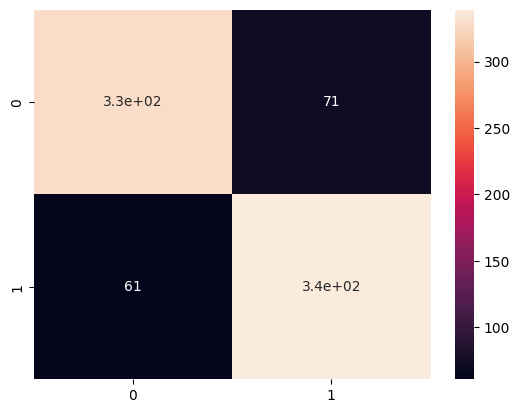

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

preds = np.argmax(model.predict(X_test), axis=1)
preds_true = np.argmax(Y_test, axis=1)

cm  = confusion_matrix(preds_true, preds)

df_cm = pd.DataFrame(cm)

sns.heatmap(df_cm, annot=True)

In [39]:
Y_test

array([[1, 0],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=uint8)

In [40]:
model.save('../models/adult_NN.h5', overwrite=True, save_format='h5')

In [41]:
model.save('../models/adult_NN', overwrite=True)

INFO:tensorflow:Assets written to: ../models/adult_NN\assets


In [42]:
tf.data.experimental.enable_debug_mode()
model_test = tf.keras.models.load_model('../models/adult_NN.h5')

In [43]:
model.load_weights('../models/adult_NN.h5')

In [44]:
X_test[0].shape

(85,)

In [45]:
model.predict(X_test[0:2], verbose=1)


1/1 [==============================] - 0s 40ms/step


array([[0.8785488 , 0.12145115],
       [0.12944728, 0.8705528 ]], dtype=float32)

RandomForest

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from joblib import dump, load

In [ ]:
# best_score = 0


# for crit in ['gini', 'entropy']:
#     for max_depth in [10, 30, None]: 
#         for estimators in [150, 200]:
#             for max_features in ['sqrt', 'log2']:
#                 for min_samples_leaf in [1,2,3]:
#                     for min_samples_split in [2,3,4]:
#                         for min_impurity_decrease in [0, 0.001, 0.01, 0.1]:
#                             classifier = RandomForestClassifier(
#                                 random_state=seed, 
#                                 criterion=crit, 
#                                 n_estimators=estimators,
#                                 verbose=0,
#                                 class_weight='balanced',
#                                 min_impurity_decrease=min_impurity_decrease,
#                                 min_samples_leaf=min_samples_leaf,
#                                 min_samples_split=min_samples_split,
#                                 max_depth=max_depth,
#                                 n_jobs=3,
#                                 max_features=max_features
#                                 )
#                             classifier.fit(X_train, Y_train)
#                             score = classifier.score(X_test, Y_test)
#                             if score > best_score:
#                                 best_score = score
#                                 print(f'New Best! Crit: {crit}, Max_depth: {max_depth}, Max_feat: {max_features}, Min_sampl_leaf: {min_samples_split} \
# MIn_samples_split {min_samples_split}, Min_impurity_dec: {min_impurity_decrease}, Estimators: {estimators} Score: {score}')

In [57]:
classifier = RandomForestClassifier(
                random_state=seed, 
                criterion='gini', 
                n_estimators=200,
                verbose=0,
                class_weight='balanced',
                min_impurity_decrease=0,
                max_depth=25,
                n_jobs=3,
                max_features='sqrt'
            )
classifier.fit(X_train, Y_train)
classifier.score(X_test, Y_test)

0.85875

In [58]:
dump(classifier, '../models/adult_RF.joblib')

['../models/adult_RF.joblib']

In [59]:
clf = load('../models/adult_RF.joblib')

In [60]:
print(Y_test[0:5])
clf.predict(X_test[0:5])

[[1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]]


array([[1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0]], dtype=uint8)

In [61]:
import pickle

with open('../models/adult_RF.pkl', 'wb') as f:
    pickle.dump(classifier, f)

with open('../models/adult_RF.pkl', 'rb') as f:
    clf_pickl = pickle.load(f)

pred = clf_pickl.predict(X_test[0:5])
type(pred)

numpy.ndarray

In [62]:
clf_pickl.predict_proba(X_test[0:10])[0]

array([[0.16451484, 0.83548516],
       [0.96742363, 0.03257637],
       [0.56207324, 0.43792676],
       [0.99826945, 0.00173055],
       [0.        , 1.        ],
       [0.53680899, 0.46319101],
       [0.77897016, 0.22102984],
       [0.05047456, 0.94952544],
       [0.5840329 , 0.4159671 ],
       [0.        , 1.        ]])